In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load Corpus

We'll use a set of bbc new-stories in this example

In [2]:
df = pd.read_csv('bbc-text.csv')

In [3]:
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [4]:
df['category'].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

## Get Tokens & Text Features

In [5]:
import nltk

In [6]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.porter import PorterStemmer

Split off the text title

Tokenize sentences

In [7]:
df['tokens'] = df['text'].apply(word_tokenize)

Strip out numbers and stem words

In [8]:
ps = PorterStemmer()

In [9]:
df['clean_text'] =  df['tokens'].apply(lambda x: " ".join([ps.stem(i) for i in x if not i.isdigit()]))

Sentence level tokenization

In [10]:
df['sentences'] = df['clean_text'].apply(sent_tokenize)

In [11]:
df['n_sentences'] = df['sentences'].apply(lambda x: len(x))

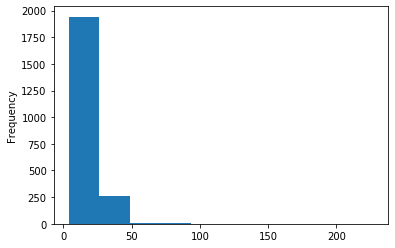

In [12]:
df['n_sentences'].plot.hist();

We'll drop the tail texts with lots of sentences for speed of training

In [13]:
df = df[df['n_sentences']<51].copy()

In [14]:
df['max_sen_length'] = df['sentences'].apply(lambda x: max([len(word_tokenize(i)) for i in x]))

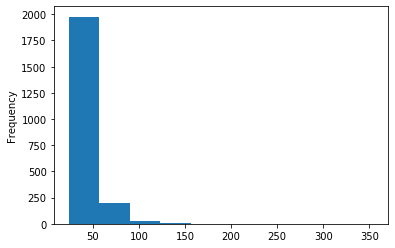

In [15]:
df['max_sen_length'].plot.hist();

And additionally drop the few texts that contain long sentences

In [16]:
df = df[df['max_sen_length']<101].copy()

In [17]:
df['text_length'] = df['clean_text'].apply(lambda x: len(word_tokenize(x)))

We will need theses properties to use as matrices dimensions in the network

In [18]:
MAX_TEXT_LENGTH = df['text_length'].max()

In [19]:
MAX_NUM_SENTS = df['n_sentences'].max()

In [20]:
MAX_SEN_LENGTH = df['max_sen_length'].max()

In [21]:
print('Max text length in words: {}\nMax sent length in words: {}\nMax No sentences: {}'
      .format(MAX_TEXT_LENGTH, MAX_SEN_LENGTH, MAX_NUM_SENTS))

Max text length in words: 1699
Max sent length in words: 100
Max No sentences: 49


Pad the sentences for use in the attention network as they all need the same dimensions

In [22]:
df['pad_sentences'] = df['sentences'].apply(lambda x: x + ([''] * (MAX_NUM_SENTS-len(x))))

### Labels

Convert labels to one-hat arrays

In [23]:
from sklearn.preprocessing import LabelBinarizer

In [24]:
one_hot = LabelBinarizer()

In [25]:
oh_labels = one_hot.fit_transform(df['category'])

In [26]:
N_LABELS = oh_labels.shape[1]

In [27]:
one_hot.classes_

array(['business', 'entertainment', 'politics', 'sport', 'tech'],
      dtype='<U13')

## Attention Network

In [28]:
from tensorflow.keras.preprocessing.text import Tokenizer

Max number of words to tokenize based on ther frequency

In [29]:
NUM_WORDS = 10000

In [30]:
tokenizer = Tokenizer(num_words=NUM_WORDS)
tokenizer.fit_on_texts(df['text'])

### Import GLOVE Embeddings

In [31]:
embeddings_index = {}

with open('glove.6B.100d.txt') as f: 
    for line in f:
        values = line.split()
        embeddings_index[values[0]] = np.asarray(values[1:], dtype='float32')

Build the glove embedding into a matrix based on the tokenization

In [32]:
embedding_matrix = np.zeros((NUM_WORDS+1, 100))

for word, idx in list(tokenizer.word_index.items())[:NUM_WORDS]:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[idx] = embedding_vector

In [33]:
embedding_matrix.shape

(10001, 100)

### Data Processing

In [34]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences

Build an data-set in the format DOCUMENTS x SENTENCES x WORDS

In [35]:
def text_processer(raw_texts, maxlen=100):
    tokens = tokenizer.texts_to_sequences(raw_texts)
    return pad_sequences(tokens, maxlen=maxlen)

In [36]:
sen_data = np.stack(df['pad_sentences'].apply(lambda x: text_processer(x, MAX_SEN_LENGTH)).values)

In [37]:
sen_data.shape

(2185, 49, 100)

In [38]:
txt_train, txt_test, x_train, x_test, y_train, y_test = train_test_split(df['clean_text'].values, sen_data, oh_labels)

## Network

In [39]:
import heirachical_attention_network as han
from tensorflow.keras.layers import Embedding

In [40]:
import importlib
importlib.reload(han);

In [41]:
embedding_layer = Embedding(NUM_WORDS+1, 
                            100,
                            weights = [embedding_matrix],
                            input_length = 100,
                            trainable = False, 
                            name = 'glove_embedding')

In [42]:
model = han.HAN(embedding_layer, 25, 25, (49, 100), N_LABELS)

In [43]:
model.fit(x_train, y_train, x_test, y_test, 10, 10)

Train on 1638 samples, validate on 547 samples
Epoch 1/10
1638/1638 [==============================] - 42s 26ms/sample - loss: 0.4740 - acc: 0.8023 - val_loss: 0.3554 - val_acc: 0.8260
Epoch 2/10
1638/1638 [==============================] - 33s 20ms/sample - loss: 0.2656 - acc: 0.8951 - val_loss: 0.1794 - val_acc: 0.9506
Epoch 3/10
1638/1638 [==============================] - 33s 20ms/sample - loss: 0.1164 - acc: 0.9684 - val_loss: 0.0866 - val_acc: 0.9740
Epoch 4/10
1638/1638 [==============================] - 34s 21ms/sample - loss: 0.0677 - acc: 0.9813 - val_loss: 0.0717 - val_acc: 0.9770
Epoch 5/10
1638/1638 [==============================] - 34s 21ms/sample - loss: 0.0510 - acc: 0.9842 - val_loss: 0.0779 - val_acc: 0.9718
Epoch 6/10
1638/1638 [==============================] - 33s 20ms/sample - loss: 0.0372 - acc: 0.9874 - val_loss: 0.0585 - val_acc: 0.9810
Epoch 7/10
1638/1638 [==============================] - 34s 21ms/sample - loss: 0.0326 - acc: 0.9896 - val_loss: 0.0598 - val

In [44]:
def test_example(n):
    """Print example along with the actual and generated tags"""
    p = model.predict(x_test[n:n+1])[0]
    top = sorted(list(zip(one_hot.classes_, p)), key=lambda x: x[1], reverse=True)
    print(txt_test[n],'\n')
    print('Tagged as:', one_hot.classes_[np.nonzero(y_test[n])],'\n')
    for i in top[:4]:
        print("{:25}:{:03.4f}".format(i[0], i[1]))

In [45]:
test_example(10)

gamer snap up new soni psp gamer have bought almost all of the first batch of soni s new playstat portabl ( psp ) game consol which went on sale in japan on sunday . thousand of peopl queu for hour to get hold of one of the psp which were ship to retail . the handheld consol can play game music and movi and goe on sale in europ and north america next year . despit the demand soni said it would not increas the 000-strong stock of psp it plan to ship by year s end . soni say it intend to ship three million of the consol by march 2005. the compani is hope to challeng the domin of nintendo in the handheld market . nintendo releas it new ds consol earlier thi year and ha alreadi rais shipment target for the devic by % . the psp is sell in japan for yen ( $ ; £98 ) while nintendo s ds consol sell in the us and japan for $ ( £78 ) . nintendo s goal is to ship million of it new nintendo ds handheld consol by march . 

Tagged as: ['tech'] 

tech                     :0.9942
business             

### Attention Extraction

In [46]:
from matplotlib import cm

The model can return the attention matrix for a sample

In [47]:
att = model.attention_matrix(x_test[0])

returns a normalized attention matrix

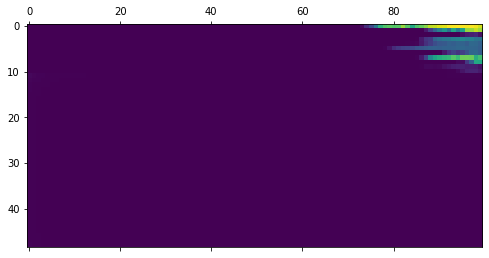

In [48]:
plt.matshow(att);

In [49]:
def plot_attention(n):
    """
    Plot the attention per word represented as a bar chart
    
    Args:
        x (int): Sample number
    """
    sample = x_test[n]
    att_mat = model.attention_matrix(sample)
    tuples = []
    trim_sample = sample[~np.all(sample==0, axis=1)]
    
    for i, r in enumerate(trim_sample):
        trimmed = r[~(r==0)]
        trim_txt = tokenizer.sequences_to_texts([trimmed])[0].split()
        att_slice = att_mat[i,-trimmed.shape[0]:]
        tuples.append((trim_txt, att_slice))
        
    f, ax = plt.subplots(len(tuples), sharex=True, sharey=True, figsize=(12, 1.5*len(tuples)))
    mx = np.max(att_mat)
    
    for i, t in enumerate(tuples):
        clrs = cm.PuBuGn(0.7*t[1]/mx)
        rects = ax[i].bar(np.arange(len(t[0])), t[1], color=clrs)
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        for j, w in enumerate(t[0]):
            ax[i].text(rects[j].get_x() + rects[j].get_width()/2., 0.02, w, ha='center', va='bottom', rotation=90)

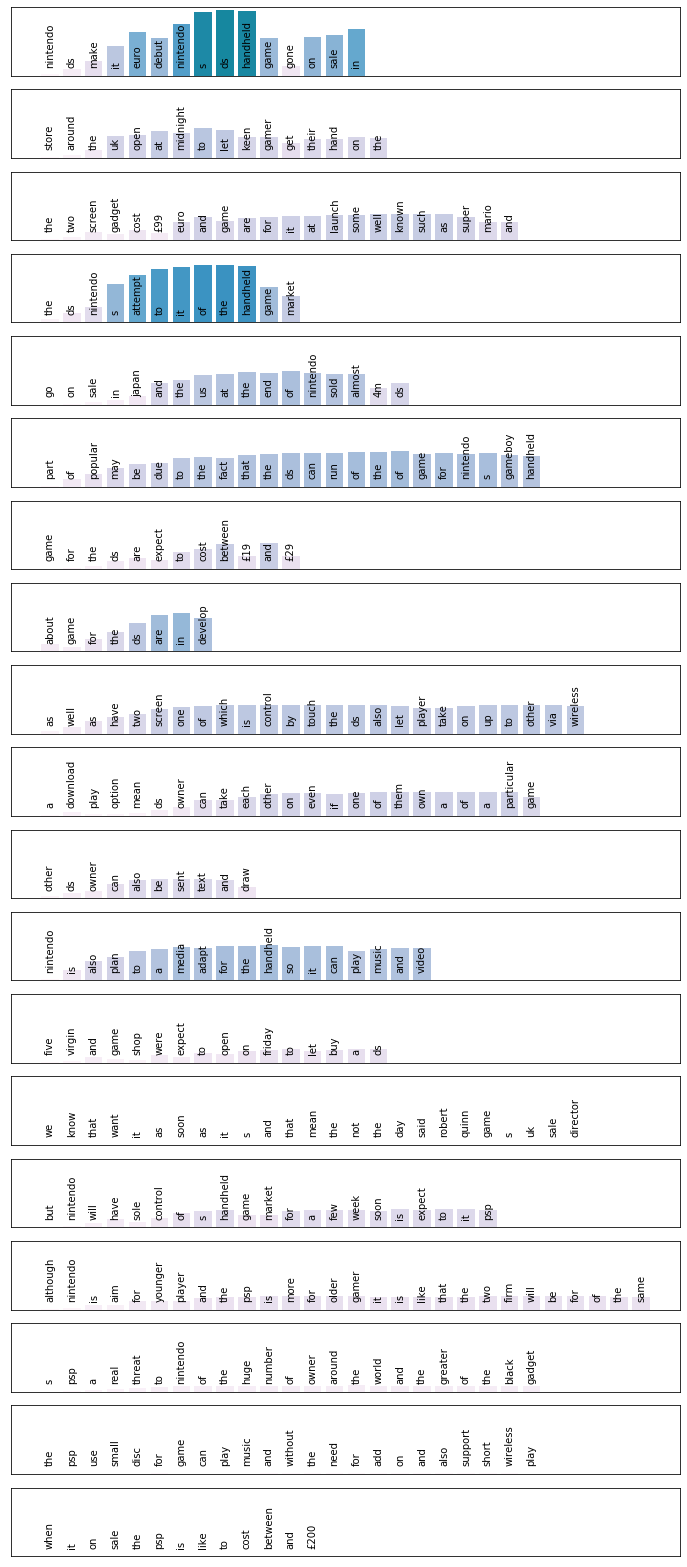

In [50]:
plot_attention(312)

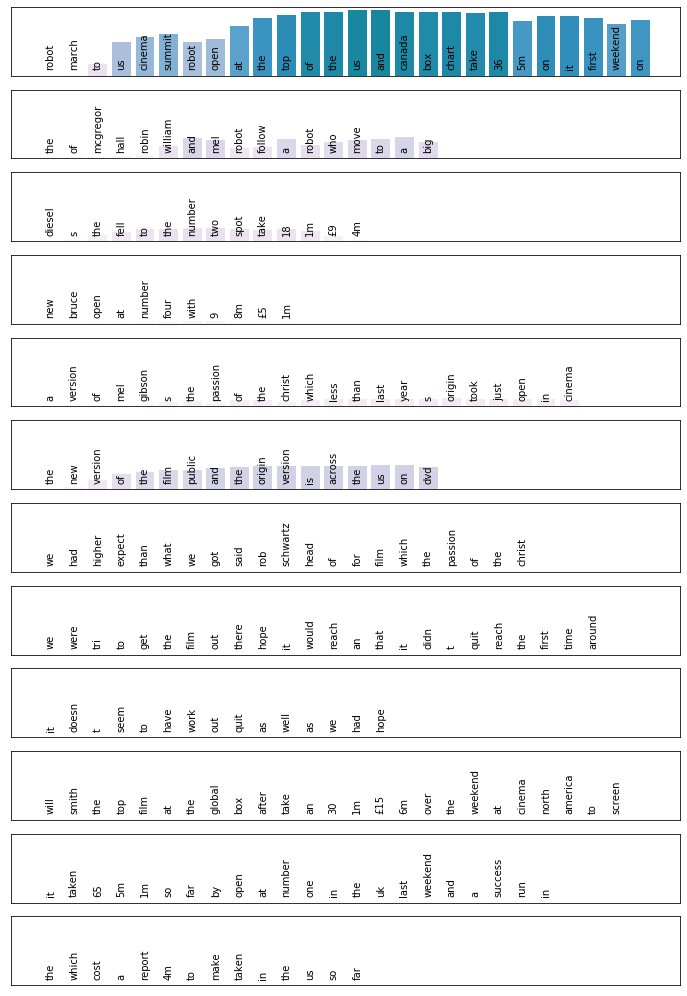

In [51]:
plot_attention(322)